<a href="https://colab.research.google.com/github/george-zakharov/ml_notebooks/blob/master/Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Homework 6

Датасет: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009

#### Light: 

решить задачу классификации на предложенном датасете с использованием Boosting моделей.



#### Pro: 

- нормализовать, стандартизовать датасет и применить техники работы с не сбалансированным датасетом;

- решить задачу классификации на предложенном датасете с использованием Boosting моделей..

# Load Libs

In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Normalization tests
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest

# Data normalization
from sklearn.preprocessing import PowerTransformer

# Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Loading dataset
wine = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/6/data/winequality-red.csv')

# User defined functions

In [0]:
# Functions for normalization test
def draw_hist_for_feature(data):
  plt.style.use('ggplot')
  data.hist(bins = 60)
  plt.show()


def chech_skew(feature):
  method_name = '\nSKEW TEST: '
  skew_ = np.abs(skew(feature))
  if (skew_ >= 0.75) and (skew_ < 1.0):
    print(method_name + 'Данные рекомендуется логарифмировать\n')
  elif skew_ >= 1:
    print(method_name + 'Данные рекомендуется нормализовать\n')
  else:
    print(method_name + 'Данные достаточно стандартизировать\n')


def check_shapiro(feature):
  method_name = '\nSHAPIRO TEST: '
  shapiro_ = np.abs(shapiro(feature))
  if (shapiro_[1] < 0.50):
    print(method_name + 'Данные рекомендуется нормализовать\n')
  else:
    print(method_name + 'Данные достаточно стандартизировать\n')


def print_stats(data, need_hist = True):
  if (need_hist == True):
    draw_hist_for_feature(data)

  print("mean : ", np.mean(data))
  print("var  : ", np.var(data))
  print("skew : ", skew(data))
  print("kurt : ", kurtosis(data))
  print("shapiro : ", shapiro(data))
  print("normaltest : ", normaltest(data))


def print_stats_all(df, need_hist = True):
  n = 1
  for feature_name in df.columns:
    print(f'\n\n{n}. {feature_name}')
    print_stats(df[feature_name], need_hist)
    chech_skew(df[feature_name])
    check_shapiro(df[feature_name])
    n += 1

In [0]:
# Data preprocessing according to skew metrics
def data_preprocessing(df):
  n = 1
  for feature_name in df.columns:
    print(f'\n\n{n}. {feature_name}')
    feature = df[feature_name]

    print_stats(feature)
    
    skew_ = np.abs(skew(feature))

    if (skew_ >= 0.75) and (skew_ < 1.0):
      print('\nДанные рекомендуется логарифмировать\n')
      feature = np.log(feature)
    elif skew_ >= 1:
      if feature.min() > 0:
        print('\nДанные рекомендуется нормализовать методом boxcox\n')
        box_cox_transform = PowerTransformer(method = 'box-cox', standardize = False)
        feature = box_cox_transform.fit_transform(feature.values.reshape(df.shape[0], -1))
      else:
        print('\nДанные рекомендуется нормализовать методом yeo-johnson\n')
        yeo_johnson_transform = PowerTransformer(method = 'yeo-johnson', standardize = False)
        feature = yeo_johnson_transform.fit_transform(feature.values.reshape(df.shape[0], -1))
    else:
      print('\nДанные достаточно стандартизировать\n')

    print_stats(pd.DataFrame(feature, columns = [feature_name]))
    chech_skew(feature)

    df[feature_name] = feature

    n += 1

  return df

In [0]:
def scale_std_minmax(df):
  print(df.shape)

  scaler = StandardScaler()
  print(scaler.fit(df.copy()))
  StandardScaler()
  result = scaler.transform(df.copy())
  result = pd.DataFrame(result, columns = df.columns)


  scaler = MinMaxScaler()
  print(scaler.fit(result))
  MinMaxScaler(copy = True, feature_range = (0, 1))
  print(scaler.data_max_)
  result = scaler.transform(result)
  result = pd.DataFrame(result, columns = df.columns)
  
  return result

# Dataset exploration

## View data

In [10]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [11]:
# Check class balance
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [16]:
wine.describe(include = 'all')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [15]:
# Check missing values
wine.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Divide features and labels

In [0]:
X = wine.drop(['quality'], axis = 1)
y = wine.quality

In [20]:
X.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


In [21]:
y.head(3)

0    5
1    5
2    5
Name: quality, dtype: int64

## Check normalization



1. fixed acidity


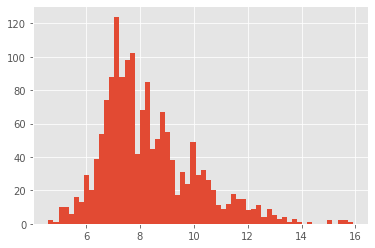

mean :  8.319637273295838
var  :  3.0295205688671296
skew :  0.9818292953262073
kurt :  1.1248563352037486
shapiro :  (0.942030668258667, 1.5255951637239901e-24)
normaltest :  NormaltestResult(statistic=224.53087840457746, pvalue=1.7528277735470436e-49)

SKEW TEST: Данные рекомендуется логарифмировать


SHAPIRO TEST: Данные рекомендуется нормализовать



2. volatile acidity


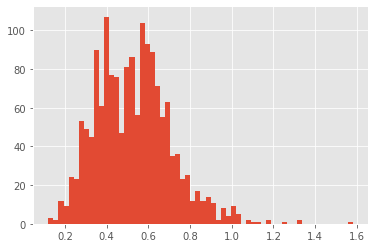

mean :  0.5278205128205131
var  :  0.03204232613332036
skew :  0.6709623963499574
kurt :  1.2179633893005306
shapiro :  (0.9743340611457825, 2.686806772838566e-16)
normaltest :  NormaltestResult(statistic=143.4193435598286, pvalue=7.192589039756692e-32)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



3. citric acid


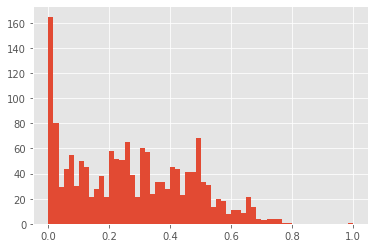

mean :  0.2709756097560964
var  :  0.037923751124940605
skew :  0.3180385895475358
kurt :  -0.7902825153036646
shapiro :  (0.9552900195121765, 1.0208196357632134e-21)
normaltest :  NormaltestResult(statistic=152.039214793795, pvalue=9.662822259281018e-34)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



4. residual sugar


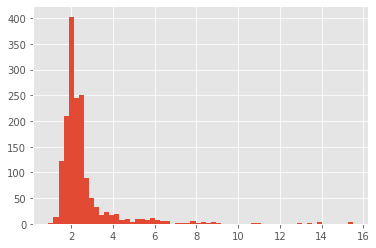

mean :  2.5388055034396517
var  :  1.9866539202699018
skew :  4.536394788805638
kurt :  28.524437824252235
shapiro :  (0.5660765171051025, 0.0)
normaltest :  NormaltestResult(statistic=1520.3239698236891, pvalue=0.0)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



5. chlorides


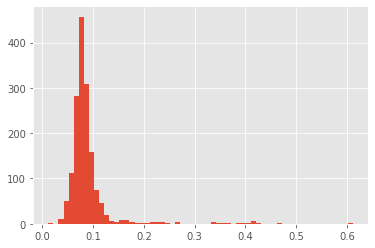

mean :  0.08746654158849257
var  :  0.0022137573233114395
skew :  5.675016527504259
kurt :  41.581708043675775
shapiro :  (0.4842468500137329, 0.0)
normaltest :  NormaltestResult(statistic=1783.1059225626427, pvalue=0.0)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



6. free sulfur dioxide


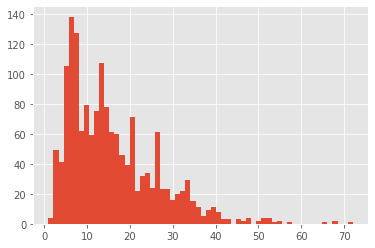

mean :  15.874921826141339
var  :  109.3464567637451
skew :  1.249393847434253
kurt :  2.01348999733378
shapiro :  (0.9018407464027405, 7.6973984391279615e-31)
normaltest :  NormaltestResult(statistic=342.2591484251238, pvalue=4.779365332171477e-75)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



7. total sulfur dioxide


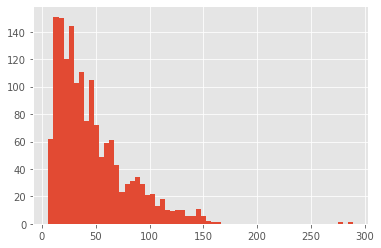

mean :  46.46779237023139
var  :  1081.4256355891553
skew :  1.5141091878506638
kurt :  3.7941717664905665
shapiro :  (0.8732253909111023, 3.5741436086741964e-34)
normaltest :  NormaltestResult(statistic=487.42725648953467, pvalue=1.433890834343538e-106)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



8. density


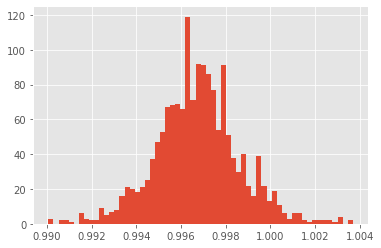

mean :  0.9967466791744831
var  :  3.559801792630711e-06
skew :  0.07122077153539946
kurt :  0.9274107990478333
shapiro :  (0.9908668398857117, 1.9400959061499634e-08)
normaltest :  NormaltestResult(statistic=30.70774994095191, pvalue=2.1473202738102222e-07)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



9. pH


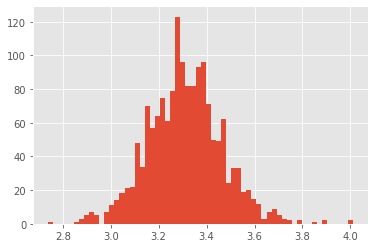

mean :  3.311113195747343
var  :  0.023820274241131745
skew :  0.19350175891005525
kurt :  0.8006714441211544
shapiro :  (0.993486762046814, 1.7136950418716879e-06)
normaltest :  NormaltestResult(statistic=33.684697471483915, pvalue=4.8468645347727716e-08)

SKEW TEST: Данные достаточно стандартизировать


SHAPIRO TEST: Данные рекомендуется нормализовать



10. sulphates


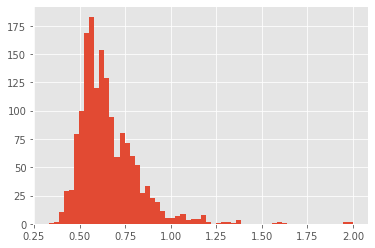

mean :  0.6581488430268921
var  :  0.028714647013983425
skew :  2.426393455449087
kurt :  11.6798841115311
shapiro :  (0.8330425024032593, 5.821617678881608e-38)
normaltest :  NormaltestResult(statistic=906.8944479227036, pvalue=1.1759065222978855e-197)

SKEW TEST: Данные рекомендуется нормализовать


SHAPIRO TEST: Данные рекомендуется нормализовать



11. alcohol


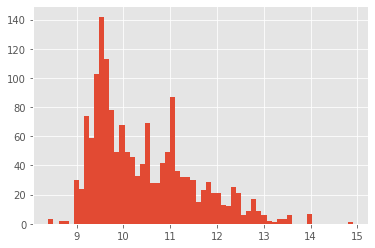

mean :  10.422983114446502
var  :  1.1349371714888994
skew :  0.8600210646566755
kurt :  0.1956543762123122
shapiro :  (0.9288389682769775, 6.643664824998876e-27)
normaltest :  NormaltestResult(statistic=154.17806951912516, pvalue=3.3163288473185496e-34)

SKEW TEST: Данные рекомендуется логарифмировать


SHAPIRO TEST: Данные рекомендуется нормализовать



In [53]:
print_stats_all(X)

# Dataset transformation



1. fixed acidity


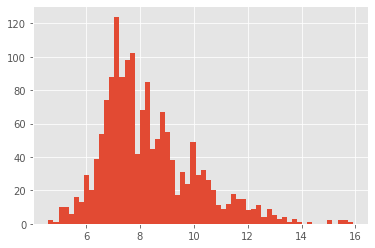

mean :  8.319637273295838
var  :  3.0295205688671296
skew :  0.9818292953262073
kurt :  1.1248563352037486
shapiro :  (0.942030668258667, 1.5255951637239901e-24)
normaltest :  NormaltestResult(statistic=224.53087840457746, pvalue=1.7528277735470436e-49)

Данные рекомендуется логарифмировать



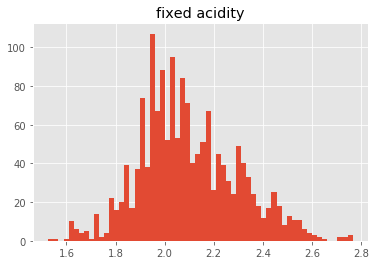

mean :  fixed acidity    2.098226
dtype: float64
var  :  fixed acidity    0.03974
dtype: float64
skew :  [0.39354537]
kurt :  [0.09695618]
shapiro :  (0.9848697185516357, 6.456312047486978e-12)
normaltest :  NormaltestResult(statistic=array([39.54165981]), pvalue=array([2.59201595e-09]))

SKEW TEST: Данные достаточно стандартизировать



2. volatile acidity


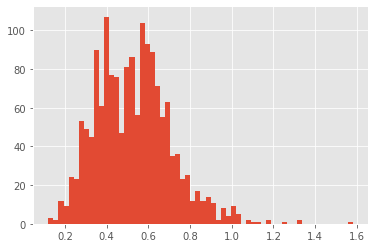

mean :  0.5278205128205131
var  :  0.03204232613332036
skew :  0.6709623963499574
kurt :  1.2179633893005306
shapiro :  (0.9743340611457825, 2.686806772838566e-16)
normaltest :  NormaltestResult(statistic=143.4193435598286, pvalue=7.192589039756692e-32)

Данные достаточно стандартизировать



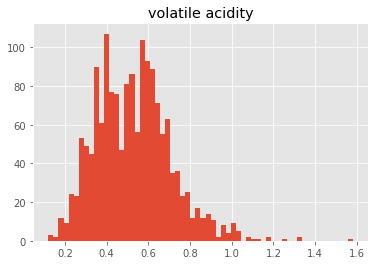

mean :  volatile acidity    0.527821
dtype: float64
var  :  volatile acidity    0.032042
dtype: float64
skew :  [0.6709624]
kurt :  [1.21796339]
shapiro :  (0.9743340611457825, 2.686806772838566e-16)
normaltest :  NormaltestResult(statistic=array([143.41934356]), pvalue=array([7.19258904e-32]))

SKEW TEST: Данные достаточно стандартизировать



3. citric acid


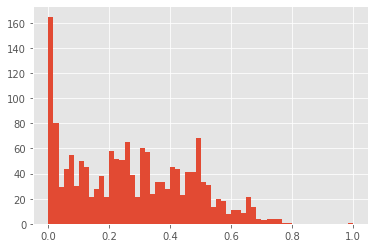

mean :  0.2709756097560964
var  :  0.037923751124940605
skew :  0.3180385895475358
kurt :  -0.7902825153036646
shapiro :  (0.9552900195121765, 1.0208196357632134e-21)
normaltest :  NormaltestResult(statistic=152.039214793795, pvalue=9.662822259281018e-34)

Данные достаточно стандартизировать



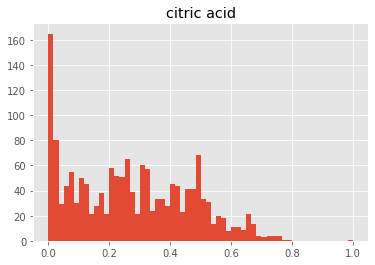

mean :  citric acid    0.270976
dtype: float64
var  :  citric acid    0.037924
dtype: float64
skew :  [0.31803859]
kurt :  [-0.79028252]
shapiro :  (0.9552900195121765, 1.0208196357632134e-21)
normaltest :  NormaltestResult(statistic=array([152.03921479]), pvalue=array([9.66282226e-34]))

SKEW TEST: Данные достаточно стандартизировать



4. residual sugar


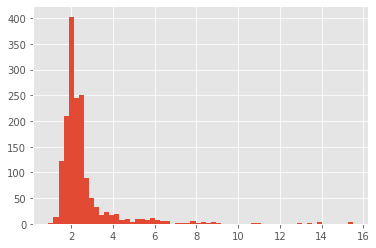

mean :  2.5388055034396517
var  :  1.9866539202699018
skew :  4.536394788805638
kurt :  28.524437824252235
shapiro :  (0.5660765171051025, 0.0)
normaltest :  NormaltestResult(statistic=1520.3239698236891, pvalue=0.0)

Данные рекомендуется нормализовать методом boxcox



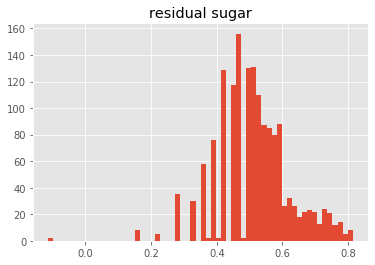

mean :  residual sugar    0.513556
dtype: float64
var  :  residual sugar    0.01211
dtype: float64
skew :  [-0.09584002]
kurt :  [1.60404381]
shapiro :  (0.9759386777877808, 1.011885569943366e-15)
normaltest :  NormaltestResult(statistic=array([62.41154248]), pvalue=array([2.80224271e-14]))

SKEW TEST: Данные достаточно стандартизировать



5. chlorides


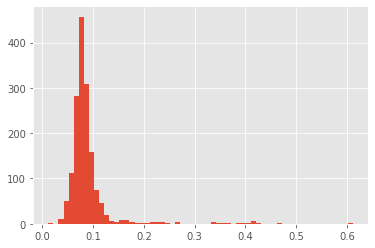

mean :  0.08746654158849257
var  :  0.0022137573233114395
skew :  5.675016527504259
kurt :  41.581708043675775
shapiro :  (0.4842468500137329, 0.0)
normaltest :  NormaltestResult(statistic=1783.1059225626427, pvalue=0.0)

Данные рекомендуется нормализовать методом boxcox



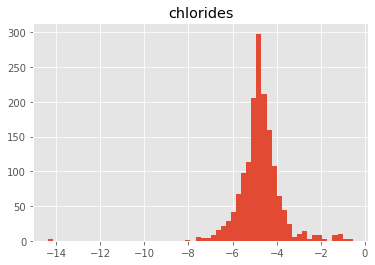

mean :  chlorides   -4.763474
dtype: float64
var  :  chlorides    0.926346
dtype: float64
skew :  [-0.49917442]
kurt :  [14.5513695]
shapiro :  (0.8716785907745361, 2.4586373518860107e-34)
normaltest :  NormaltestResult(statistic=array([412.77325778]), pvalue=array([2.33037565e-90]))

SKEW TEST: Данные достаточно стандартизировать



6. free sulfur dioxide


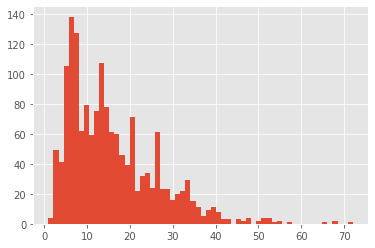

mean :  15.874921826141339
var  :  109.3464567637451
skew :  1.249393847434253
kurt :  2.01348999733378
shapiro :  (0.9018407464027405, 7.6973984391279615e-31)
normaltest :  NormaltestResult(statistic=342.2591484251238, pvalue=4.779365332171477e-75)

Данные рекомендуется нормализовать методом boxcox



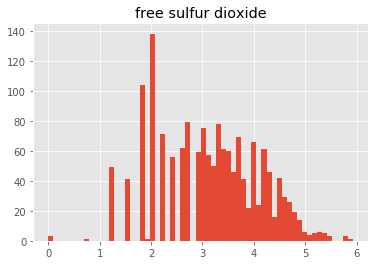

mean :  free sulfur dioxide    3.129049
dtype: float64
var  :  free sulfur dioxide    0.971227
dtype: float64
skew :  [-0.01975919]
kurt :  [-0.59777277]
shapiro :  (0.9874722361564636, 1.5522860774552782e-10)
normaltest :  NormaltestResult(statistic=array([49.9466963]), pvalue=array([1.42630598e-11]))

SKEW TEST: Данные достаточно стандартизировать



7. total sulfur dioxide


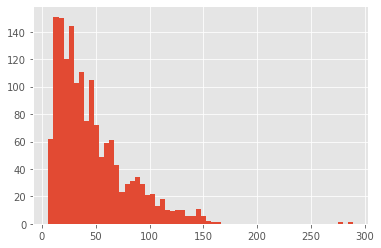

mean :  46.46779237023139
var  :  1081.4256355891553
skew :  1.5141091878506638
kurt :  3.7941717664905665
shapiro :  (0.8732253909111023, 3.5741436086741964e-34)
normaltest :  NormaltestResult(statistic=487.42725648953467, pvalue=1.433890834343538e-106)

Данные рекомендуется нормализовать методом boxcox



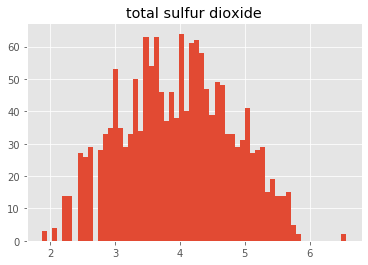

mean :  total sulfur dioxide    3.965719
dtype: float64
var  :  total sulfur dioxide    0.715565
dtype: float64
skew :  [-0.00802061]
kurt :  [-0.67038533]
shapiro :  (0.990358293056488, 8.859659672566522e-09)
normaltest :  NormaltestResult(statistic=array([71.36209297]), pvalue=array([3.19093827e-16]))

SKEW TEST: Данные достаточно стандартизировать



8. density


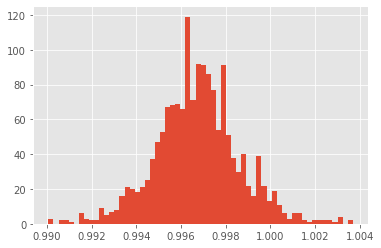

mean :  0.9967466791744831
var  :  3.559801792630711e-06
skew :  0.07122077153539946
kurt :  0.9274107990478333
shapiro :  (0.9908668398857117, 1.9400959061499634e-08)
normaltest :  NormaltestResult(statistic=30.70774994095191, pvalue=2.1473202738102222e-07)

Данные достаточно стандартизировать



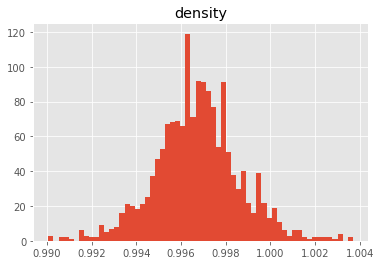

mean :  density    0.996747
dtype: float64
var  :  density    0.000004
dtype: float64
skew :  [0.07122077]
kurt :  [0.9274108]
shapiro :  (0.9908668398857117, 1.9400959061499634e-08)
normaltest :  NormaltestResult(statistic=array([30.70774994]), pvalue=array([2.14732027e-07]))

SKEW TEST: Данные достаточно стандартизировать



9. pH


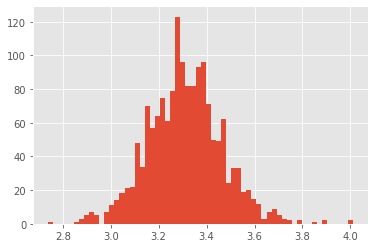

mean :  3.311113195747343
var  :  0.023820274241131745
skew :  0.19350175891005525
kurt :  0.8006714441211544
shapiro :  (0.993486762046814, 1.7136950418716879e-06)
normaltest :  NormaltestResult(statistic=33.684697471483915, pvalue=4.8468645347727716e-08)

Данные достаточно стандартизировать



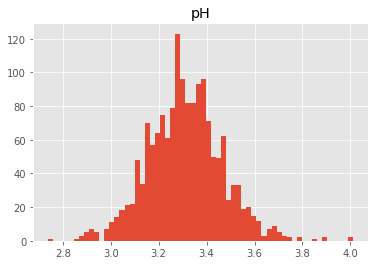

mean :  pH    3.311113
dtype: float64
var  :  pH    0.02382
dtype: float64
skew :  [0.19350176]
kurt :  [0.80067144]
shapiro :  (0.993486762046814, 1.7136950418716879e-06)
normaltest :  NormaltestResult(statistic=array([33.68469747]), pvalue=array([4.84686453e-08]))

SKEW TEST: Данные достаточно стандартизировать



10. sulphates


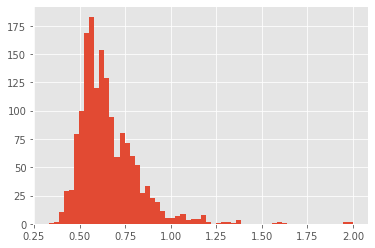

mean :  0.6581488430268921
var  :  0.028714647013983425
skew :  2.426393455449087
kurt :  11.6798841115311
shapiro :  (0.8330425024032593, 5.821617678881608e-38)
normaltest :  NormaltestResult(statistic=906.8944479227036, pvalue=1.1759065222978855e-197)

Данные рекомендуется нормализовать методом boxcox



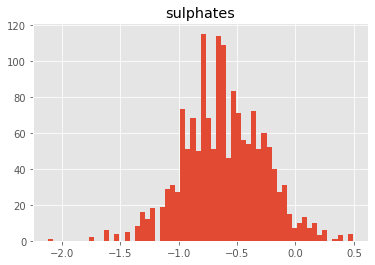

mean :  sulphates   -0.609663
dtype: float64
var  :  sulphates    0.115999
dtype: float64
skew :  [-0.02475606]
kurt :  [0.39890141]
shapiro :  (0.9964831471443176, 0.0010049439733847976)
normaltest :  NormaltestResult(statistic=array([8.24567945]), pvalue=array([0.01619845]))

SKEW TEST: Данные достаточно стандартизировать



11. alcohol


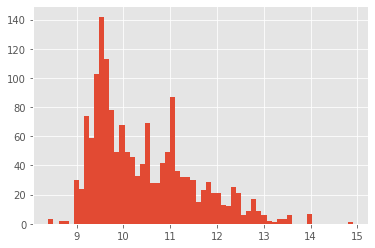

mean :  10.422983114446502
var  :  1.1349371714888994
skew :  0.8600210646566755
kurt :  0.1956543762123122
shapiro :  (0.9288389682769775, 6.643664824998876e-27)
normaltest :  NormaltestResult(statistic=154.17806951912516, pvalue=3.3163288473185496e-34)

Данные рекомендуется логарифмировать



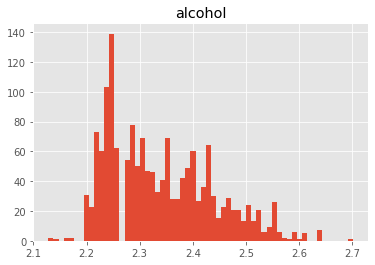

mean :  alcohol    2.339021
dtype: float64
var  :  alcohol    0.009775
dtype: float64
skew :  [0.66123544]
kurt :  [-0.28947897]
shapiro :  (0.9464339017868042, 1.154532723556871e-23)
normaltest :  NormaltestResult(statistic=array([105.75210886]), pvalue=array([1.08697946e-23]))

SKEW TEST: Данные достаточно стандартизировать



In [60]:
X_normalized = data_preprocessing(X)

In [62]:
# Check normalized data
X_normalized.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2.001480,0.70,0.00,0.450049,-4.920401,2.867882,3.861490,0.9978,3.51,-0.801405,2.240710
1,2.054124,0.88,0.00,0.572939,-4.140122,4.102521,4.686835,0.9968,3.20,-0.476630,2.282382
2,2.054124,0.76,0.04,0.530233,-4.325636,3.317116,4.421290,0.9970,3.26,-0.546246,2.282382
3,2.415914,0.28,0.56,0.450049,-4.963593,3.504207,4.550629,0.9980,3.16,-0.737642,2.282382
4,2.001480,0.70,0.00,0.450049,-4.920401,2.867882,3.861490,0.9978,3.51,-0.801405,2.240710
